<font size="6">Variational Inference - Discovering Latent States</font>

<font size="5">Purpose</font>

One of the difficulties in dealing with financial time series data is that there are many time-varying parameters, and the distributions are not stationary. Clustering approaches may be used to discover where these parameters are varying, and give us some idea of the overall stability/instability of those time-varying parameters. 

If models are built with any assumptions about the parameters of the data, and those parameters shift, then the model assumptions are invalidated and that model will fail. Mixture models based on EM (expectation-maximization) partition the data into states where the covariance matrix and mean of the parameters within each state differ significantly. A nice feature of the Dirichlet process mixture model is that is it both a clustering and generative model from which we can generate new samples based on the fitted posterior distribution. 

<font size="5">Method</font>

Using variational inference applied to time series data, the algorithm non-parametrically chooses a likely number of clusters (latent states) each with distinct <b>mean and covariance</b> parameters allowing computation of a likelihood function for the 3-dimensional point at any time step. The model optimizes the parameters of the clusters to maximize the likelihood of those parameters given the data. 

In order to define what it means to be a good approximation the Kullback-Leibler divergence (KL divergence) is a non-symmetric measure of the difference between two probability distributions 𝑃 and 𝑄, the true posterior and the approximating variational distribution (mean field variational inference - see paper https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf). 

This comes from information theory -- entropy is the average amount of information or "surprise" in the divergence between the distributions. 

$$\large KL(q||p)=E_q\Bigg[\ log\  \frac{q(Z)}{p(Z\  |\ x)}\ \Bigg]$$

In the mean-field approximation, we also assume that the latent states will be partitioned so that each partition is independent. Using KL divergence, we can derive mutually dependent equations (one for each partition) that defines 𝑄 to approximate the posterior distribution. This is done for ease of computation for the iterative approach (expectation-maximization). Maximizing the ELBO log likelihood is equivalent to minimizing the KL divergence between the approximator 𝑄 and the true posterior 𝑃. This is the ELBO constructed with Jensens inequality. 

$$\large log\:p(x | θ) ≥ E_q [log\:p(W, x | θ)] − E_q [log\:q_ν(W)]$$

Borrowing from Physics, in a system with many components that interact, those system interactions are replaced with a single average interaction (a "mean field"). The states' mean/covariances factorize, 

$$\large q(\boldsymbol{\theta}) \approx \prod_{i=1}^n q(\theta_i)$$

$$\large q(\boldsymbol{\mu}, \boldsymbol{\Sigma}) \approx \prod_{i=1}^n q(\mu_i) q(\Sigma_i)$$

One <b>shortcoming</b> of this approach, which is shown in another notebook is that the model does not preserve auto-correlation between the samples, which is expected. Thus, a different approach will be needed to introduce auto-correlation structure into synthetic data (such as fractional gaussian noise which will be covered in another notebook). 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

I will be testing with a small universe of the 10Y Treasury ETF, a Commodity basket ETF, and Tech sector ETF using data from the <b>M6 Financial Forecasting</b> (https://m6competition.com/) competition sponsored by Google and others. The goal will be time series clustering using variational inference. There are re-occurring pockets of time (regimes, or repeating latent states) where certain assets outperform the others and their precise relationship is captured by the distribution mean and covariance within that cluster assignment. 

Set num_components to a very high number since the data is fit in a non-parametric way where we need not know the number of clusters in advance. 

In [11]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 4

Create the subset of assets. We end up with a 3-dimensional multivariate gaussian system. 

In [12]:
m6 = pd.read_csv('./data/assets_m6_2022.csv')
m6_assets = pd.DataFrame()

for sym in assetlist: 
    m6_assets[sym] = m6[m6['symbol'] == sym]['price'].values

<font size="5">Z-Scoring & Auto-Correlation Decay Plots</font>

Formatting the training data. There is only training data and no test data in this exercise (it is a purely descriptive exercise). Z-scored measurements of the log price for each asset based on a rolling window. At timepoint 't' the window looks back 'w' steps to calculate mu and sigma. 

$$\huge z_t = \frac{x_t - \mu_{t-w:t}}{\sigma_{t-w:t}}$$

There are regions where the current log price is either above or below its running average (as measured in units of standard deviation) and this formatting of the data preserves long memory based on looking at the auto-correlation decay plots. <b>It is important that the running average never takes into account future data which would introduce lookahead bias, so a rolling metric based on the list comprehension is used.</b> 

The ACF function is defined as follows, 

$$ \huge \operatorname{ACF}(\tau) = \frac{\sum_{t=1}^{n-\tau} (x_t - \bar{x})(x_{t+\tau} - \bar{x})}{\sum_{t=1}^n (x_t - \bar{x})^2} $$

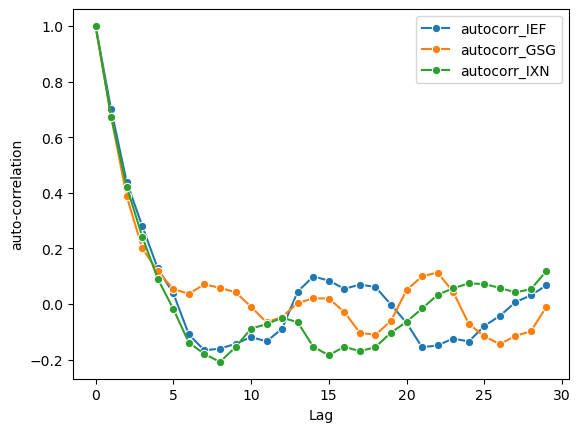

In [13]:
import scipy.stats as stats
m6_subset1 = m6_assets.copy()

# Window length 25 days
wlen = 25

# First convert to log price 
m6_subset1 = m6_subset1.apply(np.log)

# Clean data
m6_subset1 = m6_subset1.dropna().reset_index().drop(columns='index')

# Apply z-score in a rolling way that does not create lookahead bias 
rolling_zscore = lambda serie: [ stats.zscore(serie[x-wlen:x]).values[-1] for x in range(wlen, len(serie) + 1) ]

m6_subset = pd.DataFrame()
m6_subset['IEF'] = rolling_zscore(m6_subset1['IEF'])
m6_subset['GSG'] = rolling_zscore(m6_subset1['GSG'])
m6_subset['IXN'] = rolling_zscore(m6_subset1['IXN'])

# View Auto Correlation
decay_func = lambda S, _range: [S.apply(abs).autocorr(lag=Lag) for Lag in _range]
sns.lineplot(data=decay_func(m6_subset['IEF'], range(0, 30)), label='autocorr_IEF', marker='o') 
sns.lineplot(data=decay_func(m6_subset['GSG'], range(0, 30)), label='autocorr_GSG', marker='o')
sns.lineplot(data=decay_func(m6_subset['IXN'], range(0, 30)), label='autocorr_IXN', marker='o')
plt.xlabel('Lag')
plt.ylabel('auto-correlation')
plt.show()

Instantiate a non-parametric model using the dirichlet process and view the clustering results on the training data. The shaded regions on the plot represent the final state the system lands on, states[-1]. 

In [14]:
dpgmm_model = mix.BayesianGaussianMixture(n_components=num_components, 
                                          weight_concentration_prior_type='dirichlet_process', 
                                          n_init=10, 
                                          max_iter=1000000)

In [15]:
dpgmm_model.fit(m6_subset)
states = dpgmm_model.predict(m6_subset)

state_counts = np.zeros(num_components)
for M in states:
  state_counts[M] += 1 

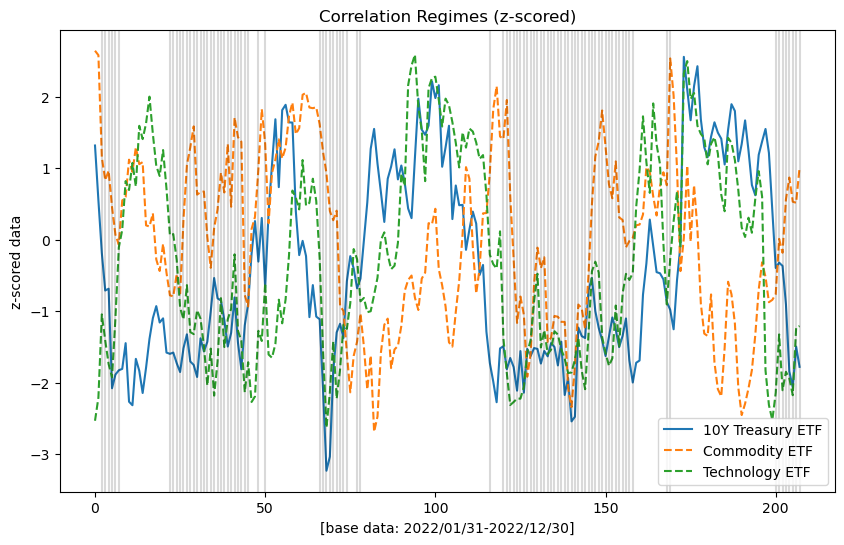

state_counts=
[55. 93. 44. 16.]
means for shaded state=
[-1.42489317  0.08382668 -1.30312418]


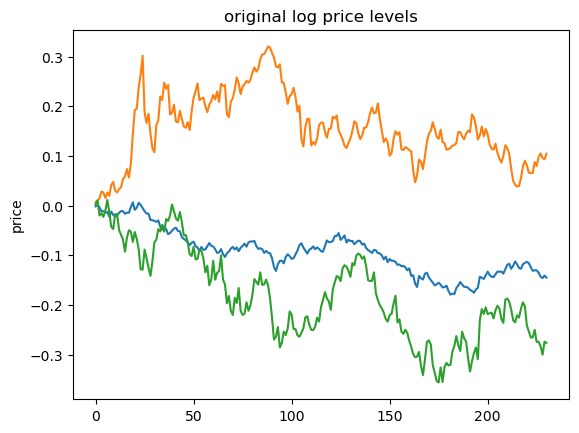

In [16]:
fig,ax = plt.subplots(figsize=(10, 6
                              ))
sns.lineplot(x=m6_subset.index, y=m6_subset['IEF'], ax=ax, label='10Y Treasury ETF')
sns.lineplot(x=m6_subset.index, y=m6_subset['GSG'], ax=ax, label='Commodity ETF', linestyle='--')
sns.lineplot(x=m6_subset.index, y=m6_subset['IXN'], ax=ax, label='Technology ETF', linestyle='--')

for M in range(len(states)): 
  if states[M] == states[-1]:
    ax.axvline(M, color='black', alpha=0.15)

ax.set_title('Correlation Regimes (z-scored)')
ax.set_ylabel('z-scored data')
ax.set_xlabel(f'[base data: 2022/01/31-2022/12/30]')
plt.show()

print('state_counts=')
print(state_counts)

print('means for shaded state=')
print(dpgmm_model.means_[states[-1]])

sns.lineplot(data=m6_assets.copy().apply(np.log).apply(np.diff).cumsum()['IEF'])
sns.lineplot(data=m6_assets.copy().apply(np.log).apply(np.diff).cumsum()['GSG'])
sns.lineplot(data=m6_assets.copy().apply(np.log).apply(np.diff).cumsum()['IXN'])
plt.title('original log price levels')
plt.ylabel('price')
plt.show()

<font size=5> Precision Matrices as Graphs </font>

Note: you may need to restart the kernel to use updated packages.


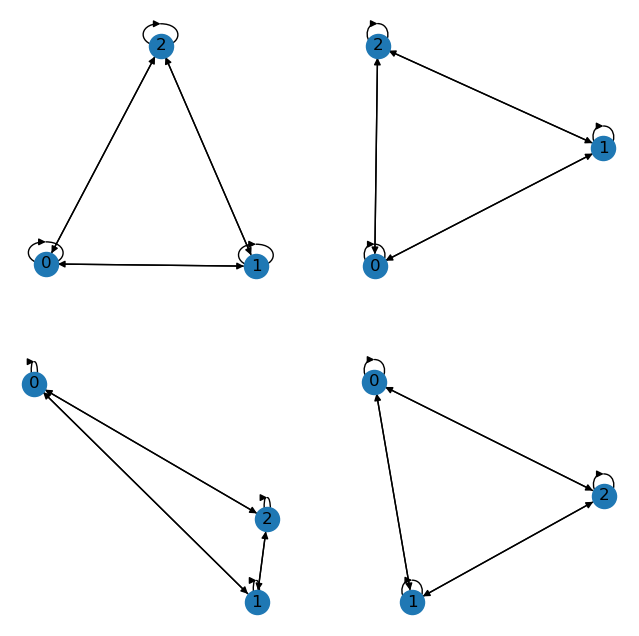

In [17]:
%pip install networkx 
import networkx as nx
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

i = 0
j = 0 
for pmat in dpgmm_model.precisions_:
    if state_counts[i] > 0: 
        ax = axes[j//2][j%2]
        G = nx.DiGraph(pmat)
        nx.draw(G, with_labels=True, ax=ax)
        j += 1
    i += 1

plt.show()